In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir DOS niveles desde blog/notebooks/ hasta la raíz del proyecto
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [3]:
# Configuration
BIG5_LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
BIG5_SEASON = '2425'  # Formato YY-YY para players_domestic
MLS_LEAGUE = 'USA-MLS'
MLS_SEASON = '2025'  # Formato YYYY para players_extras (temporada 2025 = 25-26)
MIN_MINUTES = 800

INTER_MIAMI_COLORS = {
    'primary': '#FF69B4',
    'secondary': '#00FFFF'
}

SAVE_PATH_MESSI = "../images/messi/"
os.makedirs(SAVE_PATH_MESSI, exist_ok=True)

In [4]:
# Conexión BD
db = get_db_manager()

# Query 1: Big 5 leagues temporada 24-25 (domestic)
big5_list = "', '".join(BIG5_LEAGUES)
query_big5 = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.league IN ('{big5_list}')
AND p.season = '{BIG5_SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

# Query 2: MLS temporada 25-26 (extras)
query_mls = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_extras p
WHERE p.league = '{MLS_LEAGUE}'
AND p.season = '{MLS_SEASON}'
ORDER BY p.team, p.player_name
"""

df_big5 = pd.read_sql(query_big5, db.engine)
df_mls = pd.read_sql(query_mls, db.engine)
db.close()

print(f"Big 5 (24-25): {df_big5.shape[0]} registros")
print(f"MLS (25-26): {df_mls.shape[0]} registros")

# Unir ambos datasets
df_raw = pd.concat([df_big5, df_mls], ignore_index=True)
print(f"Total combinado: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")

df_raw.head()

2025-12-12 09:59:06,695 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-12 09:59:07,163 - database.connection - INFO - Database connection successful


Big 5 (24-25): 2722 registros
MLS (25-26): 850 registros
Total combinado: 3572 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4e7d1dd4e449b118,Ross Barkley,Aston Villa,ENG-Premier League,2425,MF,ENG,30.0,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '3',...","{'understat_xa': '0.9665419245138764', 'unders..."
1,40fa60b57ca0dd78,Tyrone Mings,Aston Villa,ENG-Premier League,2425,DF,ENG,31.0,"{'FK': '0', 'OG': '0', 'Crs': '1', 'Fld': '11'...","{'understat_xa': '0.17970541678369045', 'under..."
2,b38d0a69872aad15,Youri Tielemans,Aston Villa,ENG-Premier League,2425,MF,BEL,27.0,"{'FK': '0', 'OG': '0', 'Crs': '119', 'Fld': '5...","{'understat_xa': '8.044237377122045', 'underst..."
3,32745a88508ff555,Adam Smith,Bournemouth,ENG-Premier League,2425,DF,ENG,33.0,"{'FK': '0', 'OG': '0', 'Crs': '33', 'Fld': '12...","{'understat_xa': '0.4430896267294884', 'unders..."
4,ed7d2a945e5f868a,Alex Scott,Bournemouth,ENG-Premier League,2425,MF,ENG,20.0,"{'CS': '0', 'FK': '1', 'OG': '0', '/90': '-0.2...","{'understat_xa': '1.2158988821320236', 'unders..."


In [5]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones totales: {sorted(df_raw['position'].unique())}")
print(f"Total jugadores: {df_raw.shape[0]}")

# Filtrar por posición FW/MF (posición de Messi)
df_position_filtered = df_raw[
    df_raw['position'].str.contains('FW|MF', case=False, na=False)
].copy()

print(f"\nFiltro FW/MF: {df_position_filtered.shape[0]} jugadores")

# Filtrar por minutos mínimos
df_filtered = df_position_filtered[
    df_position_filtered['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores FW/MF")
df_filtered.head()

Posiciones totales: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Total jugadores: 3572

Filtro FW/MF: 2241 jugadores
Filtro 800+ min: 1226 jugadores FW/MF


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
2,b38d0a69872aad15,Youri Tielemans,Aston Villa,ENG-Premier League,2425,MF,BEL,27.0,"{'FK': '0', 'OG': '0', 'Crs': '119', 'Fld': '5...","{'understat_xa': '8.044237377122045', 'underst..."
5,e1583e50dab3e272,Antoine Semenyo,Bournemouth,ENG-Premier League,2425,FW,GHA,24.0,"{'FK': '0', 'OG': '0', 'Crs': '59', 'Fld': '37...","{'understat_xa': '6.608794005587697', 'underst..."
7,bc1ef75f23682150,Dango Ouattara,Bournemouth,ENG-Premier League,2425,FW,BFA,22.0,"{'FK': '1', 'OG': '0', 'Crs': '88', 'Fld': '19...","{'understat_xa': '5.989504734054208', 'underst..."
9,1a3bf191b2884dfb,David Brooks,Bournemouth,ENG-Premier League,2425,"FW,MF",WAL,27.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '1.7746479772031307', 'unders..."
12,0a69ab3c5d7a3f24,Evanilson,Bournemouth,ENG-Premier League,2425,FW,BRA,24.0,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '53'...","{'understat_xa': '1.9151847725734115', 'unders..."


In [6]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [7]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [8]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [9]:
# Calcular percentiles solo para FW/MF
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")
print(f"Calculados sobre {df_filtered.shape[0]} jugadores FW/MF")

Métricas totales: 356
Percentiles totales: 356
Calculados sobre 1226 jugadores FW/MF


In [10]:
# DataFrame final consolidado con percentiles de FW/MF
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")
print(f"Percentiles calculados sobre FW/MF únicamente")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 1226 filas, 718 columnas
Percentiles calculados sobre FW/MF únicamente
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales


In [11]:
# EXPLORACIÓN MÉTRICAS DISPONIBLES
print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_nums.columns))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_nums.columns))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

print("\nMÉTRICAS PER90 DISPONIBLES:")
print("=" * 50)
per90_sorted = sorted([col for col in all_metrics.columns if col.endswith('_per90')])
for i, metric in enumerate(per90_sorted[:20], 1):
    print(f"{i:2d}. {metric}")
if len(per90_sorted) > 20:
    print(f"... y {len(per90_sorted) - 20} más")

print(f"\nTotal Per90: {len(per90_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [12]:
# Position metrics configuration
gk_metrics = [
    'Save%', 'PSxG+/-', 'CS%', 'GA90', 'pass_completion_pct',
    'Launched_Cmp%', 'Goal Kicks_Launch%', 'Sweeper_#OPA/90', 'Sweeper_AvgDist', 'SoT/90'
]

gk_titles = [
    'Save %', 'PSxG +/-', 'Clean Sheets %', 'Goals Against', 'Pass Accuracy %',
    'Long Pass %', 'Long Kicks %', 'Sweeper Actions', 'Sweeper Distance', 'Shots Faced /90'
]

df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per90', 'Aerial Duels_Won%',
    'passes_final_third_per90', 'clearances_per90', 'progressive_passes_per90', 'Tkl+Int_per90',
    'interceptions_per90', 'Blocks_Sh_per90'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

lateral_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Carries_PrgC_per90', 'Crs_per90',
    'passes_penalty_area_per90', 'expected_assists_per90', 'Touches_Att 3rd_per90', 
    'Tkl+Int_per90', 'Challenges_Tkl%', 'Take-Ons_Succ_per90'
]
lateral_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Progressive Carries', 'Crosses',
    'Box Passes', 'Expected Assists', 'Touches Final Third', 
    'Tackles + Interceptions', 'Tackle Success %', 'Dribbles'
]

mf_metrics = [
    'progressive_passes_per90', 'Carries_PrgC_per90', 'SCA_SCA90', 'expected_assists_per90',
    'passes_penalty_area_per90', 'Take-Ons_Succ_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Fld_per90', 'pass_completion_pct'
]
mf_titles = [
    'Progressive Passes', 'Progressive Carries', 'Shot Creating Actions', 'Expected Assists',
    'Box Passes', 'Dribbles', 'Tackles + Interceptions', 'Interceptions',
    'Fouls Drawn', 'Pass Accuracy %'
]

pivote_metrics = [
    'pass_completion_pct', 'progressive_passes_per90', 'Tkl+Int_per90', 'interceptions_per90',
    'Challenges_Tkl%', 'Carries_PrgC_per90', 'SCA_SCA90', 'Recov_per90',
    'Fld_per90', 'expected_assists_per90'
]
pivote_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Tackles + Interceptions', 'Interceptions',
    'Tackle Success %', 'Progressive Carries', 'Shot Creating Actions', 'Recoveries',
    'Fouls Drawn', 'Expected Assists'
]

extremo_metrics = [
    'expected_goals_per90', 'shots_per90', 'expected_assists_per90', 'Take-Ons_Succ_per90',
    'Touches_Att Pen_per90', 'SCA_SCA90', 'Crs_per90', 'Carries_PrgC_per90',
    'npxG/Sh', 'Fld_per90'
]
extremo_titles = [
    'Expected Goals', 'Shots', 'Expected Assists', 'Dribbles',
    'Touches in Box', 'Shot Creating Actions', 'Crosses', 'Progressive Carries',
    'npxG per Shot', 'Fouls Drawn'
]

fw_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'Touches_Att Pen_per90',
    'expected_assists_per90', 'Take-Ons_Succ_per90', 'npxG/Sh', 'G-xG_per90',
    'Fld_per90', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

configs = [
    ('GK', gk_metrics, gk_titles),
    ('DF Central', df_metrics, df_titles),
    ('DF Lateral', lateral_metrics, lateral_titles),
    ('MF', mf_metrics, mf_titles),
    ('MF Pivote', pivote_metrics, pivote_titles),
    ('FW Extremo', extremo_metrics, extremo_titles),
    ('FW Centro', fw_metrics, fw_titles)
]

print("POSITION METRICS VERIFICATION:")
print("=" * 50)
for pos, metrics, titles in configs:
    status = "OK" if len(metrics) == 10 and len(titles) == 10 else "ERROR"
    print(f"{status} {pos}: {len(metrics)} metrics, {len(titles)} titles")

print(f"\nTOTAL POSITIONS: {len(configs)}")

POSITION METRICS VERIFICATION:
OK GK: 10 metrics, 10 titles
OK DF Central: 10 metrics, 10 titles
OK DF Lateral: 10 metrics, 10 titles
OK MF: 10 metrics, 10 titles
OK MF Pivote: 10 metrics, 10 titles
OK FW Extremo: 10 metrics, 10 titles
OK FW Centro: 10 metrics, 10 titles

TOTAL POSITIONS: 7


In [13]:
# MESSI METRICS CONFIGURATION
messi_metrics = [
    'expected_goals_per90',
    'goals_per90',
    'expected_assists_per90',
    'assists_per90',
    'key_passes_per90',
    'Take-Ons_Succ_per90',
    'SCA_SCA90',
    'Touches_Att Pen_per90',
    'Carries_PrgC_per90',
    'Fld_per90'
]

messi_titles = [
    'Expected Goals',
    'Goals',
    'Expected Assists',
    'Assists',
    'Key Passes',
    'Dribbles',
    'Shot Creating Actions',
    'Touches in Box',
    'Progressive Carries',
    'Fouls Drawn'
]

print("MESSI METRICS CONFIGURATION:")
print("=" * 50)
status = "OK" if len(messi_metrics) == 10 and len(messi_titles) == 10 else "ERROR"
print(f"{status} Messi: {len(messi_metrics)} metrics, {len(messi_titles)} titles")
for i, (metric, title) in enumerate(zip(messi_metrics, messi_titles), 1):
    print(f"{i:2d}. {metric:30s} -> {title}")

MESSI METRICS CONFIGURATION:
OK Messi: 10 metrics, 10 titles
 1. expected_goals_per90           -> Expected Goals
 2. goals_per90                    -> Goals
 3. expected_assists_per90         -> Expected Assists
 4. assists_per90                  -> Assists
 5. key_passes_per90               -> Key Passes
 6. Take-Ons_Succ_per90            -> Dribbles
 7. SCA_SCA90                      -> Shot Creating Actions
 8. Touches_Att Pen_per90          -> Touches in Box
 9. Carries_PrgC_per90             -> Progressive Carries
10. Fld_per90                      -> Fouls Drawn


In [14]:
# SEARCH FOR MESSI
print("SEARCHING FOR MESSI:")
print("=" * 50)

search_patterns = ['Messi', 'Lionel Messi', 'Lionel']

messi_id = None
messi_found = False

for pattern in search_patterns:
    if messi_found:
        break
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\nPattern '{pattern}' results:")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}, {p['season']}) - {minutes} min")
            
            # Buscar específicamente Inter Miami CF temporada 2526
            if 'Inter Miami' in p['team'] and p['season'] == MLS_SEASON:
                messi_id = p['unique_player_id']
                print(f"  ✓ FOUND: Messi (Inter Miami 25-26) -> {messi_id}")
                messi_found = True
                break

if messi_id:
    print("\n" + "=" * 50)
    print(f"✓ MESSI FOUND: {messi_id}")
    
    # Mostrar info completa
    messi_row = df_final[df_final['unique_player_id'] == messi_id].iloc[0]
    print(f"  Name: {messi_row['player_name']}")
    print(f"  Team: {messi_row['team']}")
    print(f"  League: {messi_row['league']}")
    print(f"  Season: {messi_row['season']}")
    print(f"  Position: {messi_row['position']}")
else:
    print("\n✗ MESSI NOT FOUND IN DATASET")
    print("Verifica que:")
    print("  1. MLS 25-26 está en la BD")
    print("  2. Inter Miami CF tiene datos")
    print("  3. Messi cumple MIN_MINUTES")

SEARCHING FOR MESSI:

Pattern 'Messi' results:
  1c9da57ff12d512f - Junior Messias (Genoa, ITA-Serie A, MF,FW, 2425) - 847.0 min
  c489e46447d6ba7f - Lionel Messi (Inter Miami, USA-MLS, FW,MF, 2025) - 2421.0 min
  ✓ FOUND: Messi (Inter Miami 25-26) -> c489e46447d6ba7f

✓ MESSI FOUND: c489e46447d6ba7f
  Name: Lionel Messi
  Team: Inter Miami
  League: USA-MLS
  Season: 2025
  Position: FW,MF


MESSI INDIVIDUAL RADAR GENERATION

Processing: Messi Individual Radar
  Player ID: c489e46447d6ba7f
  Dataset: 1226 players (FW/MF)
  Percentiles: Ya calculados en df_final
  Team: Inter Miami
  Team logo: Inter Miami -> ../caras/extras/messi.png
  Colors: ['#FF69B4', '#00FFFF']

✓ Completed: Messi_2526_combined.png


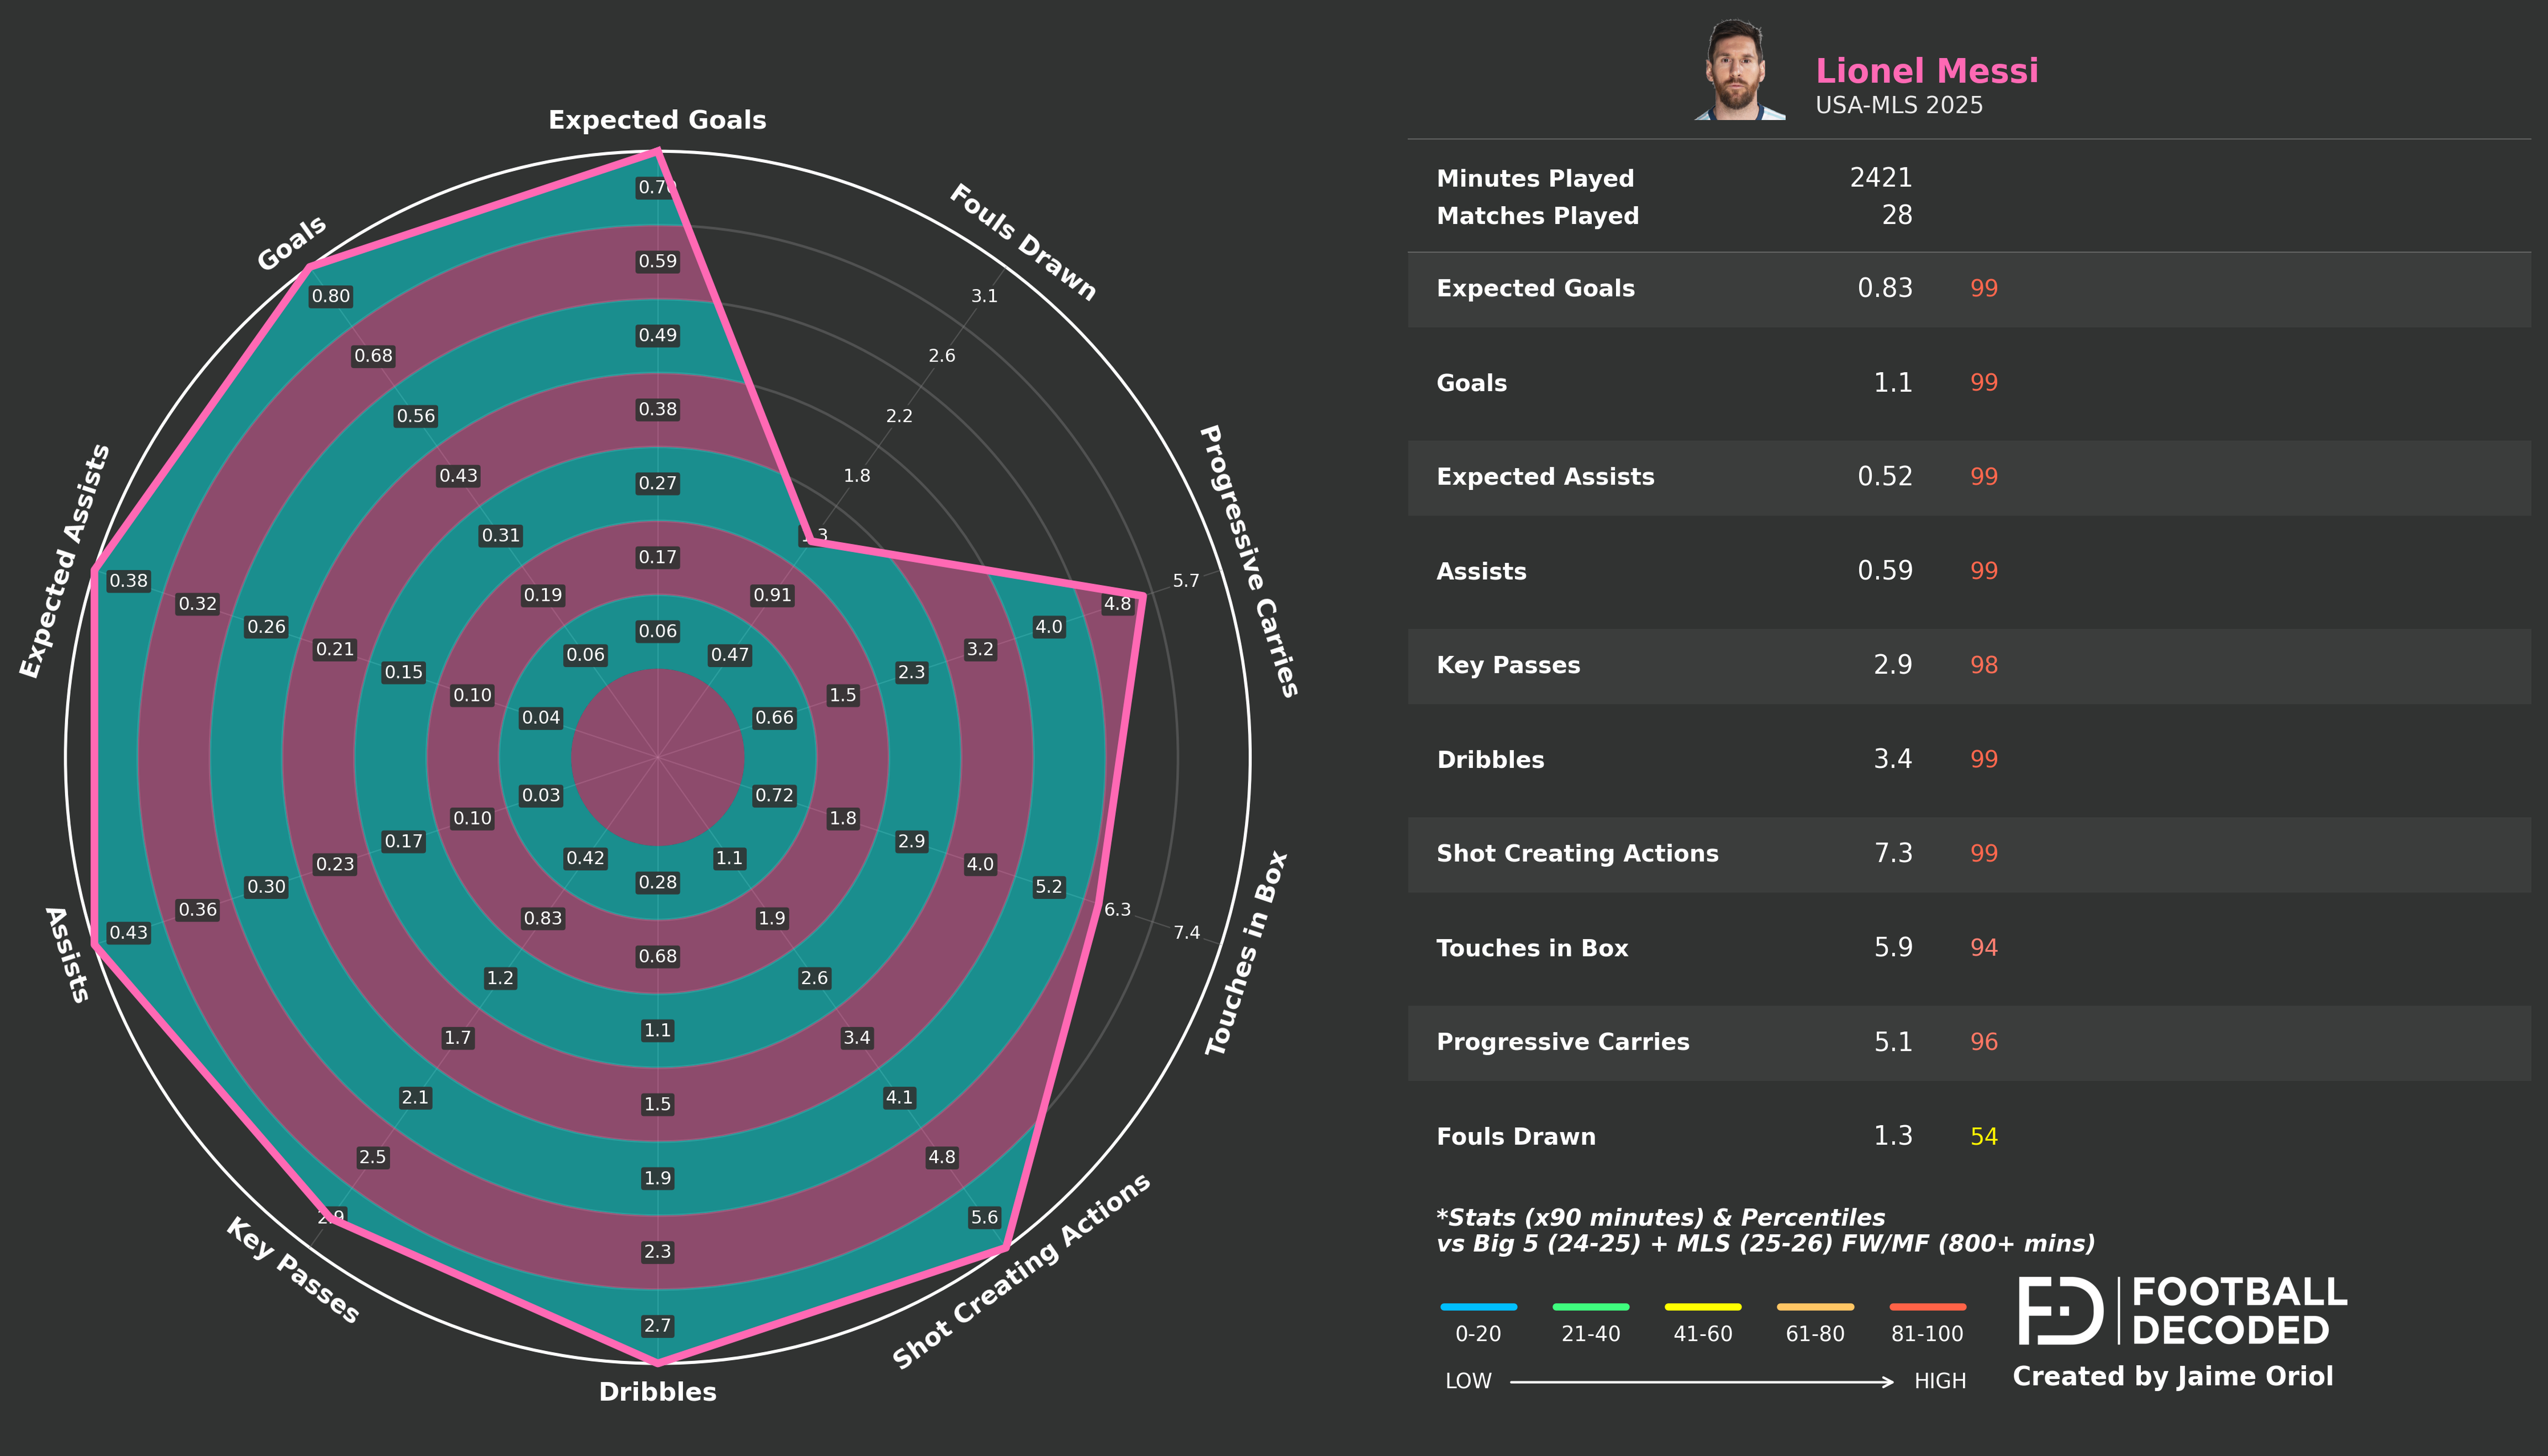


MESSI RADAR SUMMARY
✓ Radar generado exitosamente
Files saved in: ../images/messi/
  - Messi_2526_radar.png
  - Messi_2526_table.png
  - Messi_2526_combined.png

Comparación vs 1226 jugadores FW/MF
Dataset: Big 5 (24-25) + MLS (25-26)


In [17]:
# GENERATE MESSI INDIVIDUAL RADAR
if messi_id:
    from viz.swarm_radar import create_player_radar
    from viz.stats_radar import create_stats_table, combine_radar_and_table
    from IPython.display import Image as IPImage, display
    
    print("MESSI INDIVIDUAL RADAR GENERATION")
    print("=" * 50)
    
    # df_final ya está filtrado por FW/MF con percentiles calculados
    position_df = df_final.copy()
    position_filter = "FW/MF"
    
    print(f"\nProcessing: Messi Individual Radar")
    print(f"  Player ID: {messi_id}")
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    print(f"  Percentiles: Ya calculados en df_final")
    
    # Get player team
    player_team = position_df.loc[position_df['unique_player_id'] == messi_id, 'team'].iloc[0]
    print(f"  Team: {player_team}")
    
    # Inter Miami colors
    team_colors = [INTER_MIAMI_COLORS['primary'], INTER_MIAMI_COLORS['secondary']]
    team_logos = {player_team: '../caras/extras/messi.png'}
    
    print(f"  Team logo: {player_team} -> {team_logos[player_team]}")
    print(f"  Colors: {team_colors}")
    
    try:
        # Radar individual
        create_player_radar(
            df_data=position_df,
            player_1_id=messi_id,
            player_2_id=None,
            metrics=messi_metrics,
            metric_titles=messi_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_MESSI}Messi_2526_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        # Tabla individual
        create_stats_table(
            df_data=position_df,
            player_1_id=messi_id,
            player_2_id=None,
            metrics=messi_metrics,
            metric_titles=messi_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_MESSI}Messi_2526_table.png",
            footer_text=f"Stats (x90 minutes) & Percentiles\nvs Big 5 (24-25) + MLS (25-26) {position_filter} ({MIN_MINUTES}+ mins)",
            show_plot=False
        )
        
        # Combinar
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_MESSI}Messi_2526_radar.png",
            table_path=f"{SAVE_PATH_MESSI}Messi_2526_table.png",
            output_path=f"{SAVE_PATH_MESSI}Messi_2526_combined.png"
        )
        
        print(f"\n✓ Completed: Messi_2526_combined.png")
        
        # Mostrar imagen
        display(IPImage(f"{SAVE_PATH_MESSI}Messi_2526_combined.png"))
        
        print("\n" + "=" * 50)
        print("MESSI RADAR SUMMARY")
        print("=" * 50)
        print("✓ Radar generado exitosamente")
        print(f"Files saved in: {SAVE_PATH_MESSI}")
        print("  - Messi_2526_radar.png")
        print("  - Messi_2526_table.png")
        print("  - Messi_2526_combined.png")
        print(f"\nComparación vs {position_df.shape[0]} jugadores {position_filter}")
        print(f"Dataset: Big 5 (24-25) + MLS (25-26)")
        
    except Exception as e:
        print(f"\n✗ Error generating Messi radar: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("\n✗ Cannot generate radar: Messi not found")